<a href="https://colab.research.google.com/github/svohra10/sales-predictions/blob/main/Final_Sales_Prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Prediciton Project
Tej Rai

In [ ]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
sales_predictions = '/content/drive/MyDrive/Part-time Data Science - Python Basics/02 Pandas for Data Science /sales_predictions.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df =  pd.read_csv(sales_predictions)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
#how many rows and columns 
df.shape

(8523, 12)

In [ ]:
#column data types
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
#finding duplicates 
#no duplicate values
df.duplicated().any()

False

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
#find correlation to see if missing values should be dropped 
na_item = df['Item_Weight'].isna()  == True
na_size = df['Outlet_Size'].isna() == True
df.groupby(na_size)['Outlet_Location_Type'].value_counts()

Outlet_Size  Outlet_Location_Type
False        Tier 3                  2795
             Tier 1                  2388
             Tier 2                   930
True         Tier 2                  1855
             Tier 3                   555
Name: Outlet_Location_Type, dtype: int64

In [ ]:
df.groupby('Outlet_Location_Type')['Outlet_Size'].value_counts()

Outlet_Location_Type  Outlet_Size
Tier 1                Small          1458
                      Medium          930
Tier 2                Small           930
Tier 3                Medium         1863
                      High            932
Name: Outlet_Size, dtype: int64

In [ ]:
#There is correlation
#Fill NaN with "small" in small markets and "medium" in medium markets 

In [ ]:
outlet_small = df['Outlet_Location_Type'] == 'Tier 2'
outlet_medium = df['Outlet_Location_Type'] == 'Tier 3'
df.loc[outlet_small & na_size, 'Outlet_Size'] = 'Small'
df.loc[outlet_medium & na_size, 'Outlet_Size'] = 'Medium'
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
df['Item_Weight'].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

In [ ]:
df['Item_Weight'].median()

12.6

In [ ]:
df['Item_Weight'].mode()

0    12.15
dtype: float64

In [ ]:
# split X and y, you are predicting price
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# instantiate the column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector= make_column_selector(dtype_include='object')

In [ ]:
#instantiate the standard scaler, OneHotEncoder and Imputers
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [ ]:
# Setup the pipelines for the numeric and categorical data
num_processor = make_pipeline(mean_imputer, scaler)
cat_processor = make_pipeline(freq_imputer, encoder)

In [ ]:
# Make a linear regression instance
reg = LinearRegression()

In [ ]:
scaler_tuple = (num_processor, num_selector)
encoder_tuple = (cat_processor, cat_selector)
transformer = make_column_transformer(scaler_tuple ,encoder_tuple, remainder='passthrough')

In [ ]:
# define a baseline model using the 'mean' strategy
# put your Columntransformer and the baseline model into a pipeline
# fit your pipe onto the training data
dummy = DummyRegressor(strategy='mean')
base_pipe = make_pipeline(transformer, dummy)

base_pipe.fit(X_train, y_train);

In [ ]:
# define a function that takes true and predicted values as arguments
# and prints all 4 metrics

def eval_model(true, pred):
  """Takes true and predicted values (arrays) and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MAE {mae},\n MSE {mse},\n RMSE: {rmse},\n R^2: {r2} ')

In [ ]:
# find MAE, MSE, RMSE on the baseline model for both the train and test data
print('Train Evaluation')
eval_model(y_train, base_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, base_pipe.predict(X_test))

Train Evaluation
MAE 1360.2184410159132,
 MSE 2959455.7045265585,
 RMSE: 1720.306863477141,
 R^2: 0.0 

Test Evaluation
MAE 1326.121044678208,
 MSE 2772144.4627103633,
 RMSE: 1664.9758144520788,
 R^2: -0.004772483978719766 


In [ ]:
# instantiate a linear regression model
# put your ColumnTransformer and linear regression model into a pipeline
# fit your pipe on the training data

lin_reg_pipe = make_pipeline(transformer, LinearRegression())
lin_reg_pipe.fit(X_train, y_train)

In [ ]:
# find MAE, MSE, RMSE on the linear regression model for both the train and test data
print('Train Evaluation')
eval_model(y_train, lin_reg_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, lin_reg_pipe.predict(X_test))

Train Evaluation
MAE 739.2760449311639,
 MSE 977123.5130532003,
 RMSE: 988.4955806948255,
 R^2: 0.6698299921980024 

Test Evaluation
MAE 824436034238.8871,
 MSE 1.2955778906176712e+26,
 RMSE: 11382345499138.88,
 R^2: -4.69586283418678e+19 


In [ ]:
tree_reg_pipe = make_pipeline(transformer, DecisionTreeRegressor())
tree_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f96b833be10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                   

In [ ]:
# find MAE, MSE, RMSE on the  tree regression model for both the train and test data
print('Train Evaluation')
eval_model(y_train, tree_reg_pipe.predict(X_train))

print('\nTest Evaluation')
eval_model(y_test, tree_reg_pipe.predict(X_test))

Train Evaluation
MAE 1.2005415435245748e-16,
 MSE 2.4643264323299693e-29,
 RMSE: 4.96419825584149e-15,
 R^2: 1.0 

Test Evaluation
MAE 991.2643480994836,
 MSE 2121896.3048036736,
 RMSE: 1456.6730260438248,
 R^2: 0.23091200707543724 


I would use the tree regression due to the R^2 value being 1. 

In [ ]:
#replace inconsistent items in "Item_fat_content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
df.describe()


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:
df['Item_Outlet_Sales'].head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

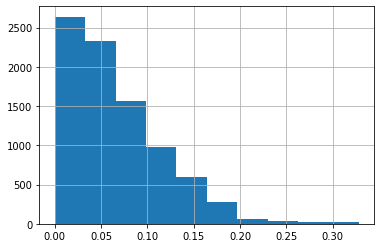

In [ ]:
# Histogram for item visbility 
df['Item_Visibility'].hist()

There are a lot of items with low levels of visibility in the store. Based on these these items can be placed in areas with higher visabilty to increase their sales.

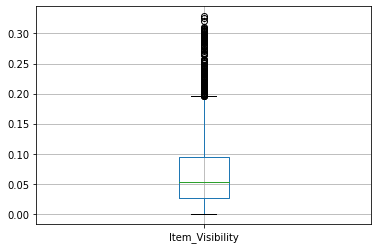

In [ ]:
# Boxplot for item visbility 
df.boxplot(column = 'Item_Visibility');

Majority of the items have a low visibility, but there are some outliers. 

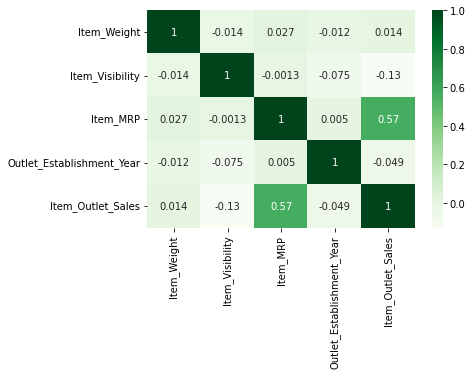

In [ ]:
#generate heat map to see correlation
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)

there is low corrleation on the heat map other than item_MRP. This is showing a moderate correlation. 



In [ ]:
df['Item_Type']

0                       Dairy
1                 Soft Drinks
2                        Meat
3       Fruits and Vegetables
4                   Household
                ...          
8518              Snack Foods
8519             Baking Goods
8520       Health and Hygiene
8521              Snack Foods
8522              Soft Drinks
Name: Item_Type, Length: 8523, dtype: object

[Text(0, 0.5, 'Item Type'),
 Text(0.5, 0, 'Item Sales'),
 Text(0.5, 1.0, 'Item Sales Based on Type')]

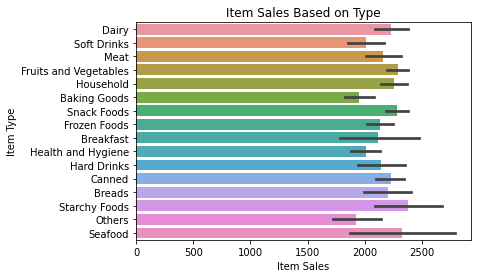

In [ ]:
sns.barplot(data=df,y='Item_Type',x='Item_Outlet_Sales').set(title = 'Item Sales Based on Type', xlabel = 'Item Sales',
                                                             ylabel = 'Item Type')

Seafood items account for the most sales with Starchy foods coming in second. Seafood also has the largest amount of varience. 

In [ ]:
fat_filter = df['Item_Fat_Content']
fat_filter

0       Low Fat
1       Regular
2       Low Fat
3       Regular
4       Low Fat
         ...   
8518    Low Fat
8519    Regular
8520    Low Fat
8521    Regular
8522    Low Fat
Name: Item_Fat_Content, Length: 8523, dtype: object

[Text(0, 0.5, 'Item Type'),
 Text(0.5, 0, 'Item Visibility'),
 Text(0.5, 1.0, 'Item Visbility Based on Type')]

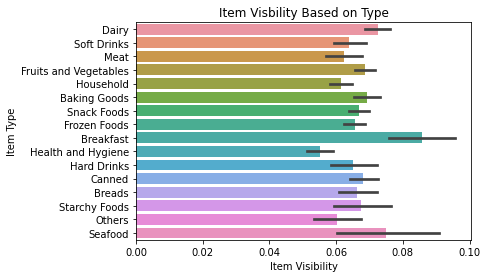

In [ ]:
# Display how Item Visiblity for type of food 
sns.barplot(data=df,y='Item_Type',x='Item_Visibility').set(title = 'Item Visbility Based on Type',
                                                           xlabel = 'Item Visibility', ylabel = 'Item Type')

Breakfast items are the most visible with seafood sa the second. Seafood is the most sold items and the one of the most visible.